In [3]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import random
import os
import tensorflow as tf

tf.random.set_seed(2)
np.random.seed(42)
random.seed(42)
os.environ["PYTHONHASHSEED"] = str(42)

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
class DataStorage:
    root = "C:/Users/user/Desktop/Workspace/MachineLearning/Datasets/prosumers/"

    data_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
        "row_id",
    ]
    client_cols = [
        "product_type",
        "county",
        "eic_count",
        "installed_capacity",
        "is_business",
        "date",
    ]
    gas_prices_cols = ["forecast_date", "lowest_price_per_mwh", "highest_price_per_mwh"]
    electricity_prices_cols = ["forecast_date", "euros_per_mwh"]
    forecast_weather_cols = [
        "latitude",
        "longitude",
        "hours_ahead",
        "temperature",
        "dewpoint",
        "cloudcover_high",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_total",
        "10_metre_u_wind_component",
        "10_metre_v_wind_component",
        "forecast_datetime",
        "direct_solar_radiation",
        "surface_solar_radiation_downwards",
        "snowfall",
        "total_precipitation",
    ]
    historical_weather_cols = [
        "datetime",
        "temperature",
        "dewpoint",
        "rain",
        "snowfall",
        "surface_pressure",
        "cloudcover_total",
        "cloudcover_low",
        "cloudcover_mid",
        "cloudcover_high",
        "windspeed_10m",
        "winddirection_10m",
        "shortwave_radiation",
        "direct_solar_radiation",
        "diffuse_radiation",
        "latitude",
        "longitude",
    ]
    location_cols = ["longitude", "latitude", "county"]
    target_cols = [
        "target",
        "county",
        "is_business",
        "product_type",
        "is_consumption",
        "datetime",
    ]

    def __init__(self):
        self.df_data = pl.read_csv(
            os.path.join(self.root, "train.csv"),
            columns=self.data_cols,
            try_parse_dates=True,
        )
        self.df_client = pl.read_csv(
            os.path.join(self.root, "client.csv"),
            columns=self.client_cols,
            try_parse_dates=True,
        )
        self.df_gas_prices = pl.read_csv(
            os.path.join(self.root, "gas_prices.csv"),
            columns=self.gas_prices_cols,
            try_parse_dates=True,
        )
        self.df_electricity_prices = pl.read_csv(
            os.path.join(self.root, "electricity_prices.csv"),
            columns=self.electricity_prices_cols,
            try_parse_dates=True,
        )
        self.df_forecast_weather = pl.read_csv(
            os.path.join(self.root, "forecast_weather.csv"),
            columns=self.forecast_weather_cols,
            try_parse_dates=True,
        )
        self.df_historical_weather = pl.read_csv(
            os.path.join(self.root, "historical_weather.csv"),
            columns=self.historical_weather_cols,
            try_parse_dates=True,
        )
        self.df_weather_station_to_county_mapping = pl.read_csv(
            os.path.join(self.root, "weather_station_to_county_mapping.csv"),
            columns=self.location_cols,
            try_parse_dates=True,
        )
        self.df_data = self.df_data.filter(
            pl.col("datetime") >= pd.to_datetime("2022-01-01")
        )
        self.df_target = self.df_data.select(self.target_cols)

        self.schema_data = self.df_data.schema
        self.schema_client = self.df_client.schema
        self.schema_gas_prices = self.df_gas_prices.schema
        self.schema_electricity_prices = self.df_electricity_prices.schema
        self.schema_forecast_weather = self.df_forecast_weather.schema
        self.schema_historical_weather = self.df_historical_weather.schema
        self.schema_target = self.df_target.schema

        self.df_weather_station_to_county_mapping = (
            self.df_weather_station_to_county_mapping.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
        )

    def update_with_new_data(
        self,
        df_new_client,
        df_new_gas_prices,
        df_new_electricity_prices,
        df_new_forecast_weather,
        df_new_historical_weather,
        df_new_target,
    ):
        df_new_client = pl.from_pandas(
            df_new_client[self.client_cols], schema_overrides=self.schema_client
        )
        df_new_gas_prices = pl.from_pandas(
            df_new_gas_prices[self.gas_prices_cols],
            schema_overrides=self.schema_gas_prices,
        )
        df_new_electricity_prices = pl.from_pandas(
            df_new_electricity_prices[self.electricity_prices_cols],
            schema_overrides=self.schema_electricity_prices,
        )
        df_new_forecast_weather = pl.from_pandas(
            df_new_forecast_weather[self.forecast_weather_cols],
            schema_overrides=self.schema_forecast_weather,
        )
        df_new_historical_weather = pl.from_pandas(
            df_new_historical_weather[self.historical_weather_cols],
            schema_overrides=self.schema_historical_weather,
        )
        df_new_target = pl.from_pandas(
            df_new_target[self.target_cols], schema_overrides=self.schema_target
        )

        self.df_client = pl.concat([self.df_client, df_new_client]).unique(
            ["date", "county", "is_business", "product_type"]
        )
        self.df_gas_prices = pl.concat([self.df_gas_prices, df_new_gas_prices]).unique(
            ["forecast_date"]
        )
        self.df_electricity_prices = pl.concat(
            [self.df_electricity_prices, df_new_electricity_prices]
        ).unique(["forecast_date"])
        self.df_forecast_weather = pl.concat(
            [self.df_forecast_weather, df_new_forecast_weather]
        ).unique(["forecast_datetime", "latitude", "longitude", "hours_ahead"])
        self.df_historical_weather = pl.concat(
            [self.df_historical_weather, df_new_historical_weather]
        ).unique(["datetime", "latitude", "longitude"])
        self.df_target = pl.concat([self.df_target, df_new_target]).unique(
            ["datetime", "county", "is_business", "product_type", "is_consumption"]
        )

    def preprocess_test(self, df_test):
        df_test = df_test.rename(columns={"prediction_datetime": "datetime"})
        df_test = pl.from_pandas(
            df_test[self.data_cols[1:]], schema_overrides=self.schema_data
        )
        return df_test

In [5]:
class FeaturesGenerator:
    def __init__(self, data_storage):
        self.data_storage = data_storage

    def _add_general_features(self, df_features):
        df_features = (
            df_features.with_columns(
                pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
                pl.col("datetime").dt.hour().alias("hour"),
                pl.col("datetime").dt.day().alias("day"),
                pl.col("datetime").dt.weekday().alias("weekday"),
                pl.col("datetime").dt.month().alias("month"),
                pl.col("datetime").dt.year().alias("year"),
            )
            .with_columns(
                pl.concat_str(
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    separator="_",
                ).alias("segment"),
            )
            .with_columns(
                (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
                (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
                (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
                (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
            )
        )
        return df_features

    def _add_client_features(self, df_features):
        df_client = self.data_storage.df_client

        df_features = df_features.join(
            df_client.with_columns(
                (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
            ),
            on=["county", "is_business", "product_type", "date"],
            how="left",
        )
        return df_features

    def _add_forecast_weather_features(self, df_features):
        df_forecast_weather = self.data_storage.df_forecast_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_forecast_weather = (
            df_forecast_weather.rename({"forecast_datetime": "datetime"})
            .filter((pl.col("hours_ahead") >= 22) & pl.col("hours_ahead") <= 45)
            .drop("hours_ahead")
            .with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_forecast_weather_date = (
            df_forecast_weather.group_by("datetime").mean().drop("county")
        )

        df_forecast_weather_local = (
            df_forecast_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [7 * 24 , 0]:
            df_features = df_features.join(
                df_forecast_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_forecast_{hours_lag}h",
            )
            df_features = df_features.join(
                df_forecast_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_forecast_local_{hours_lag}h",
            )

        return df_features

    def _add_historical_weather_features(self, df_features):
        df_historical_weather = self.data_storage.df_historical_weather
        df_weather_station_to_county_mapping = (
            self.data_storage.df_weather_station_to_county_mapping
        )

        df_historical_weather = (
            df_historical_weather.with_columns(
                pl.col("latitude").cast(pl.datatypes.Float32),
                pl.col("longitude").cast(pl.datatypes.Float32),
            )
            .join(
                df_weather_station_to_county_mapping,
                how="left",
                on=["longitude", "latitude"],
            )
            .drop("longitude", "latitude")
        )

        df_historical_weather_date = (
            df_historical_weather.group_by("datetime").mean().drop("county")
        )

        df_historical_weather_local = (
            df_historical_weather.filter(pl.col("county").is_not_null())
            .group_by("county", "datetime")
            .mean()
        )

        for hours_lag in [2 * 24, 7 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )
            df_features = df_features.join(
                df_historical_weather_local.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ),
                on=["county", "datetime"],
                how="left",
                suffix=f"_historical_local_{hours_lag}h",
            )

        for hours_lag in [1 * 24]:
            df_features = df_features.join(
                df_historical_weather_date.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag),
                    pl.col("datetime").dt.hour().alias("hour"),
                )
                .filter(pl.col("hour") <= 10)
                .drop("hour"),
                on="datetime",
                how="left",
                suffix=f"_historical_{hours_lag}h",
            )

        return df_features

    def _add_target_features(self, df_features):
        df_target = self.data_storage.df_target

        df_target_all_type_sum = (
            df_target.group_by(["datetime", "county", "is_business", "is_consumption"])
            .sum()
            .drop("product_type")
        )

        df_target_all_county_type_sum = (
            df_target.group_by(["datetime", "is_business", "is_consumption"])
            .sum()
            .drop("product_type", "county")
        )

        for hours_lag in [
            2 * 24,
            3 * 24,
            4 * 24,
            5 * 24,
            6 * 24,
            7 * 24,
            8 * 24,
            9 * 24,
            10 * 24,
            11 * 24,
            12 * 24,
            13 * 24,
            14 * 24,
        ]:
            df_features = df_features.join(
                df_target.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_{hours_lag}h"}),
                on=[
                    "county",
                    "is_business",
                    "product_type",
                    "is_consumption",
                    "datetime",
                ],
                how="left",
            )

        for hours_lag in [2 * 24, 3 * 24, 7 * 24, 14 * 24]:
            df_features = df_features.join(
                df_target_all_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_type_sum_{hours_lag}h"}),
                on=["county", "is_business", "is_consumption", "datetime"],
                how="left",
            )

            df_features = df_features.join(
                df_target_all_county_type_sum.with_columns(
                    pl.col("datetime") + pl.duration(hours=hours_lag)
                ).rename({"target": f"target_all_county_type_sum_{hours_lag}h"}),
                on=["is_business", "is_consumption", "datetime"],
                how="left",
                suffix=f"_all_county_type_sum_{hours_lag}h",
            )

        cols_for_stats = [
            f"target_{hours_lag}h" for hours_lag in [2 * 24, 3 * 24, 4 * 24, 5 * 24]
        ]
        df_features = df_features.with_columns(
            df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),
            df_features.select(cols_for_stats)
            .transpose()
            .std()
            .transpose()
            .to_series()
            .alias(f"target_std"),
        )

        for target_prefix, lag_nominator, lag_denomonator in [
            ("target", 24 * 7, 24 * 14),
            ("target", 24 * 2, 24 * 9),
            ("target", 24 * 3, 24 * 10),
            ("target", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 2, 24 * 3),
            ("target_all_type_sum", 24 * 7, 24 * 14),
            ("target_all_county_type_sum", 24 * 2, 24 * 3),
            ("target_all_county_type_sum", 24 * 7, 24 * 14),
        ]:
            df_features = df_features.with_columns(
                (
                    pl.col(f"{target_prefix}_{lag_nominator}h")
                    / (pl.col(f"{target_prefix}_{lag_denomonator}h") + 1e-3)
                ).alias(f"{target_prefix}_ratio_{lag_nominator}_{lag_denomonator}")
            )

        return df_features

    def _reduce_memory_usage(self, df_features):
        df_features = df_features.with_columns(pl.col(pl.Float64).cast(pl.Float32))
        return df_features

    def _drop_columns(self, df_features):
        df_features = df_features.drop(
            "date", "datetime", "hour", "dayofyear"
        )
        return df_features

    def _to_pandas(self, df_features, y):
        cat_cols = [
            "county",
            "is_business",
            "product_type",
            "is_consumption",
            "segment",
        ]

        if y is not None:
            df_features = pd.concat([df_features.to_pandas(), y.to_pandas()], axis=1)
        else:
            df_features = df_features.to_pandas()

        df_features = df_features.set_index("row_id")
        df_features[cat_cols] = df_features[cat_cols].astype("category")

        return df_features

    def generate_features(self, df_prediction_items):
        if "target" in df_prediction_items.columns:
            df_prediction_items, y = (
                df_prediction_items.drop("target"),
                df_prediction_items.select("target"),
            )
        else:
            y = None

        df_features = df_prediction_items.with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )

        for add_features in [
            self._add_general_features,
            self._add_client_features,
            self._add_forecast_weather_features,
            self._add_historical_weather_features,
            self._add_target_features,
            self._reduce_memory_usage,
            self._drop_columns,
        ]:
            df_features = add_features(df_features)

        df_features = self._to_pandas(df_features, y)

        return df_features

In [175]:
import xgboost as xgb

class Model:
    def __init__(self):
        self.model_params = {
            'n_estimators' : 2000,
            'learning_rate' : 0.2,
            'max_depth' : 8,
            'max_leaves' : 100,
            'min_child_weight' : 8,
            'reg_alpha' : 8.0,
            'reg_lambda' : 1.5,
            'num_parallel_tree' : 3,
            'subsample' : 0.75,
            'colsample_bytree' : 0.75,
            'enable_categorical' : True,
            'tree_method' : 'hist',
            'device' : 'cuda',
            'random_state' : 42
        }
    
        self.model_consumption = xgb.XGBRegressor(**self.model_params)
        self.model_production = xgb.XGBRegressor(**self.model_params)


    def fit(self, X_1, X_2, y_1, y_2, val_X_1, val_X_2, val_y_1, val_y_2):
        self.model_consumption.fit(
            X_1, y_1, eval_set = [(X_1, y_1), (val_X_1, val_y_1)], eval_metric = 'mae', verbose = False
        )

        self.model_production.fit(
            X_2, y_2, eval_set = [(X_2, y_2), (val_X_2, val_y_2)], eval_metric = 'mae', verbose = False
        )
    
    def predict(self, X_1, X_2):
        predictions = {}
        predictions['consumption'] = self.model_consumption.predict(
            X_1
        ).clip(0)

        predictions['production'] = self.model_production.predict(
            X_2
        ).clip(0)

        return predictions

In [124]:
data_storage = DataStorage()
features_generator = FeaturesGenerator(data_storage=data_storage)

In [125]:
df_train_features = features_generator.generate_features(data_storage.df_data)
df_train_features = df_train_features[df_train_features['target'].notnull()]

C:\Users\user\AppData\Local\Temp\ipykernel_14140\841248224.py:225: DeprecationWarning: The `axis` parameter for `DataFrame.mean` is deprecated. Use `DataFrame.mean_horizontal()` to perform horizontal aggregation.
  df_features.select(cols_for_stats).mean(axis=1).alias(f"target_mean"),


In [126]:
import holidays
import datetime

estonian_holidays = holidays.country_holidays('EE', years=range(2021, 2026))
estonian_holidays = list(estonian_holidays.keys())

def add_holidays_as_binary_features(df):
    df['country_holiday'] = df.apply(lambda row: (datetime.date(row['year'], row['month'], row['day']) in estonian_holidays) * 1, axis=1)

    return df

df_train_features = add_holidays_as_binary_features(df_train_features)

In [128]:
mask_1 = df_train_features['is_consumption'] == 1
X_1 = df_train_features[mask_1].drop(columns=['target'])
y_1 = df_train_features[mask_1]['target']

mask_2 = df_train_features['is_consumption'] == 0
X_2 = df_train_features[mask_2].drop(columns=['target'])
y_2 = df_train_features[mask_2]['target']

from sklearn.model_selection import train_test_split
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_1, y_1, test_size = 0.2, random_state = 42)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2, y_2, test_size = 0.2, random_state = 42)

In [176]:
model = Model()
model.fit(X_train_1, X_train_2, y_train_1, y_train_2, X_val_1, X_val_2, y_val_1, y_val_2)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [177]:
from sklearn.metrics import mean_absolute_error

prediction = model.predict(X_val_1, X_val_2)
prediction_1 = prediction['consumption']
prediction_2 = prediction['production']

print(mean_absolute_error(y_val_1, prediction_1))
print(mean_absolute_error(y_val_2, prediction_2))

24.474910229229415
12.834726061032482


In [ ]:
23.851105
11.850853

In [24]:
X_train = df_train_features.drop('target', axis = 1)
y_train = df_train_features['target']

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [178]:
params = {
            'n_estimators' : 2000,
            'learning_rate' : 0.2,
            'max_depth' : 8,
            'max_leaves' : 100,
            'min_child_weight' : 8,
            'reg_alpha' : 8.0,
            'reg_lambda' : 1.5,
            'num_parallel_tree' : 3,
            'subsample' : 0.75,
            'colsample_bytree' : 0.75,
            'enable_categorical' : True,
            'tree_method' : 'hist',
            'device' : 'cuda',
            'random_state' : 42
        }

all_model = xgb.XGBRegressor(**params)

all_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device='cuda', early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.4, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=100,
             min_child_weight=8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=3, random_state=42, ...)

In [179]:
prediction = all_model.predict(X_valid)
mean_absolute_error(y_valid, prediction)

21.387095459670515

In [ ]:
20.820069 >> 21.372336
learning_rate 2 >> 4

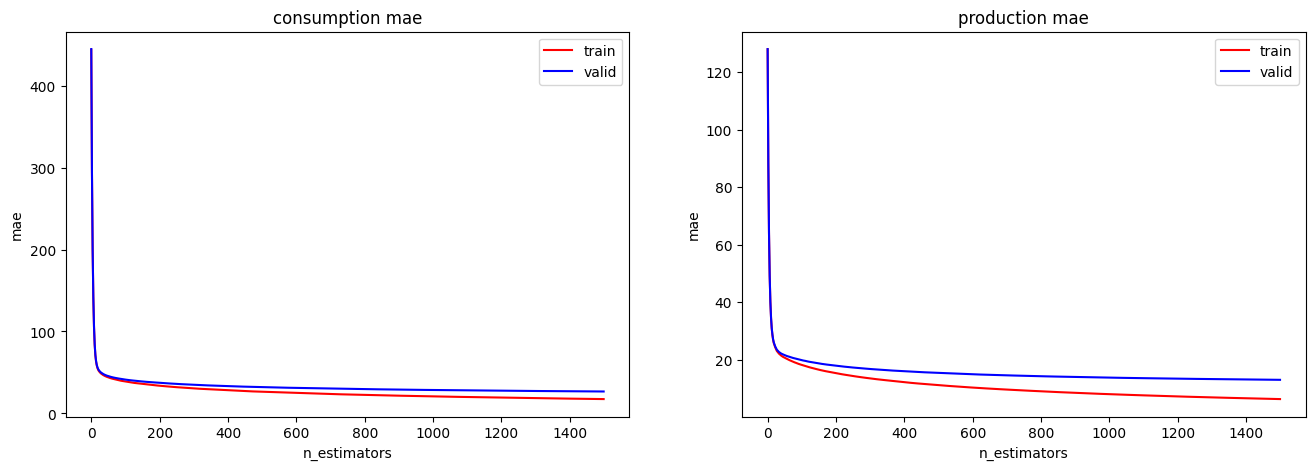

In [49]:
x = model.model_consumption.evals_result()
train_error = x['validation_0']['mae']
valid_error = x['validation_1']['mae']

plt.figure(figsize = (16, 5))
plt.subplot(1, 2, 1)
plt.plot(train_error, 'r-', label = 'train')
plt.plot(valid_error, 'b-', label = 'valid')
plt.title('consumption mae')
plt.legend(loc = 'upper right')
plt.xlabel('n_estimators')
plt.ylabel('mae')

y = model.model_production.evals_result()
train_error = y['validation_0']['mae']
valid_error = y['validation_1']['mae']

plt.subplot(1, 2, 2)
plt.plot(train_error, 'r-', label = 'train')
plt.plot(valid_error, 'b-', label = 'valid')
plt.title('production mae')
plt.legend(loc = 'upper right')
plt.xlabel('n_estimators')
plt.ylabel('mae')

plt.show()

In [17]:
from sklearn.metrics import mean_squared_error

def plot_learning_curve(model, X, y, X_val, y_val):
    train_error, valid_error = [], []
    
    for i in np.linspace(1, len(X), 50):
        idx = int(i)
        print(f'{idx} / {len(X)} 개의 데이터 훈련 시작')
        model.fit(X[:idx], y[:idx])
        train_predict = model.predict(X[:idx])
        valid_predict = model.predict(X_val)
        train_error.append(mean_squared_error(y[:idx], train_predict))
        valid_error.append(mean_squared_error(y_val, valid_predict))
    
    plt.plot(np.sqrt(train_error), 'r-', label = 'train')
    plt.plot(np.sqrt(valid_error), 'b-', label = 'valid')
    plt.title(f'{train_error[-1]}, {valid_error[-1]}')
    plt.legend()

In [18]:
params = {
    'n_estimators' : 1500,
    'learning_rate' : 0.08,
    'gamma' : 4.0,
    'max_depth' : 20,
    'max_leaves' : 40,
    'min_child_weight' : 7,
    'reg_alpha' : 3.5,
    'reg_lambda' : 1.5,
    'num_parallel_tree' : 3,
    'subsample' : 0.75,
    'colsample_bytree' : 0.75,
    'enable_categorical' : True,
    'tree_method' : 'hist',
    'device' : 'cuda',
    'random_state' : 42
        }

test = xgb.XGBRegressor(**params)

plot_learning_curve(test, X_train_1, y_train_1, X_val_1, y_val_1)
plt.show()

1 / 660760 개의 데이터 훈련 시작
13485 / 660760 개의 데이터 훈련 시작


KeyboardInterrupt: 

1 / 660760 개의 데이터 훈련 시작
13485 / 660760 개의 데이터 훈련 시작
26970 / 660760 개의 데이터 훈련 시작
40455 / 660760 개의 데이터 훈련 시작
53940 / 660760 개의 데이터 훈련 시작
67425 / 660760 개의 데이터 훈련 시작
80910 / 660760 개의 데이터 훈련 시작
94395 / 660760 개의 데이터 훈련 시작
107880 / 660760 개의 데이터 훈련 시작
121364 / 660760 개의 데이터 훈련 시작
134849 / 660760 개의 데이터 훈련 시작
148334 / 660760 개의 데이터 훈련 시작
161819 / 660760 개의 데이터 훈련 시작
175304 / 660760 개의 데이터 훈련 시작
188789 / 660760 개의 데이터 훈련 시작
202274 / 660760 개의 데이터 훈련 시작
215759 / 660760 개의 데이터 훈련 시작
229243 / 660760 개의 데이터 훈련 시작
242728 / 660760 개의 데이터 훈련 시작
256213 / 660760 개의 데이터 훈련 시작
269698 / 660760 개의 데이터 훈련 시작
283183 / 660760 개의 데이터 훈련 시작
296668 / 660760 개의 데이터 훈련 시작
310153 / 660760 개의 데이터 훈련 시작
323638 / 660760 개의 데이터 훈련 시작
337122 / 660760 개의 데이터 훈련 시작
350607 / 660760 개의 데이터 훈련 시작
364092 / 660760 개의 데이터 훈련 시작
377577 / 660760 개의 데이터 훈련 시작
391062 / 660760 개의 데이터 훈련 시작
404547 / 660760 개의 데이터 훈련 시작
418032 / 660760 개의 데이터 훈련 시작
431517 / 660760 개의 데이터 훈련 시작
445001 / 660760 개의 데이터 훈련 시작
458486 / 660760 개의 데이터 훈련 

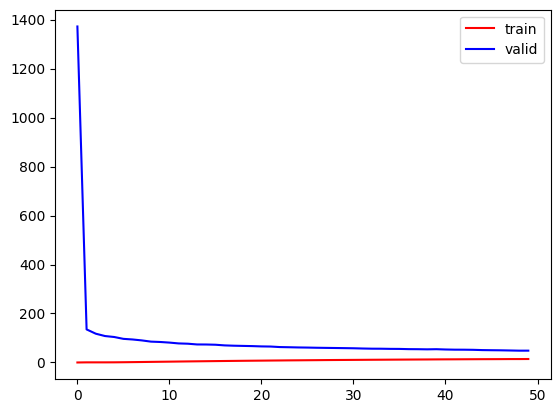

In [52]:
test_2 = xgb.XGBRegressor(**params)

plot_learning_curve(test_2, X_train_2, y_train_2, X_val_2, y_val_2)
plt.show()

In [18]:
from sklearn.metrics import get_scorer_names

get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',